In [1]:
import keras 
import keras_genomics
import numpy as np
import keras.layers as k1

from keras import backend as K 
from keras.layers.core import Dropout 
from keras.layers.core import Flatten
from keras.layers import Input
from keras.engine import Layer
from keras.models import Sequential 
from keras.engine.base_layer import InputSpec
from keras.models import Model
from keras.models import load_model
from keras.layers.convolutional import Conv1D
from keras.utils import conv_utils
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

Using TensorFlow backend.


In [2]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
from keras.initializers import Initializer
def _compute_fans(shape, data_format='channels_last'):
    """Computes the number of input and output units for a weight shape.
    # Arguments
        shape: Integer shape tuple.
        data_format: Image data format to use for convolution kernels.
            Note that all kernels in Keras are standardized on the
            `channels_last` ordering (even when inputs are set
            to `channels_first`).
    # Returns
        A tuple of scalars, `(fan_in, fan_out)`.
    # Raises
        ValueError: in case of invalid `data_format` argument.
    """
    if len(shape) == 2:
        fan_in = shape[0]
        fan_out = shape[1]
    elif len(shape) in {3, 4, 5}:
        # Assuming convolution kernels (1D, 2D or 3D).
        # TH kernel shape: (depth, input_depth, ...)
        # TF kernel shape: (..., input_depth, depth)
        if data_format == 'channels_first':
            receptive_field_size = np.prod(shape[2:])
            fan_in = shape[1] * receptive_field_size
            fan_out = shape[0] * receptive_field_size
        elif data_format == 'channels_last':
            receptive_field_size = np.prod(shape[:-2])
            fan_in = shape[-2] * receptive_field_size
            fan_out = shape[-1] * receptive_field_size
        else:
            raise ValueError('Invalid data_format: ' + data_format)
    else:
        # No specific assumptions.
        fan_in = np.sqrt(np.prod(shape))
        fan_out = np.sqrt(np.prod(shape))
    return fan_in, fan_out

class RevcompVarianceScaling(Initializer):
    def __init__(self, scale=1.0,
                 mode='fan_in',
                 distribution='normal',
                 seed=None):
        if scale <= 0.:
            raise ValueError('`scale` must be a positive float. Got:', scale)
        mode = mode.lower()
        if mode not in {'fan_in', 'fan_out', 'fan_avg'}:
            raise ValueError('Invalid `mode` argument: '
                             'expected on of {"fan_in", "fan_out", "fan_avg"} '
                             'but got', mode)
        distribution = distribution.lower()
        if distribution not in {'normal', 'uniform'}:
            raise ValueError('Invalid `distribution` argument: '
                             'expected one of {"normal", "uniform"} '
                             'but got', distribution)
        self.scale = scale
        self.mode = mode
        self.distribution = distribution
        self.seed = seed

    def __call__(self, shape, dtype=None):
        fan_in, fan_out = _compute_fans(shape)
        fan_out = fan_out*2 #revcomp kernel underestimates fan_out
        print("fanin:",fan_in, "fanout:",fan_out, self.scale, self.mode)
        scale = self.scale
        if self.mode == 'fan_in':
            scale /= max(1., fan_in)
        elif self.mode == 'fan_out':
            scale /= max(1., fan_out)
        else:
            scale /= max(1., float(fan_in + fan_out) / 2)
        if self.distribution == 'normal':
            # 0.879... = scipy.stats.truncnorm.std(a=-2, b=2, loc=0., scale=1.)
            stddev = np.sqrt(scale) / .87962566103423978
            return K.truncated_normal(shape, 0., stddev,
                                      dtype=dtype, seed=self.seed)
        else:
            limit = np.sqrt(3. * scale)
            return K.random_uniform(shape, -limit, limit,
                                    dtype=dtype, seed=self.seed)

    def get_config(self):
        return {
            'scale': self.scale,
            'mode': self.mode,
            'distribution': self.distribution,
            'seed': self.seed
        }

In [4]:
from seqdataloader.batchproducers import coordbased
import gzip
import numpy as np

class ColsInBedFile(
    coordbased.coordstovals.core.AbstractSingleNdarrayCoordsToVals):
    def __init__(self, gzipped_bed_file, **kwargs):
        super(ColsInBedFile, self).__init__(**kwargs)
        self.gzipped_bed_file = gzipped_bed_file
        coords_to_vals = {}
        for row in gzip.open(gzipped_bed_file, 'rb'):
            row = row.decode("utf-8").rstrip()
            split_row = row.split("\t")
            chrom_start_end = split_row[0]+":"+split_row[1]+"-"+split_row[2]
            vals = np.array([float(x) for x in split_row[4:]])
            coords_to_vals[chrom_start_end] = vals
        self.coords_to_vals = coords_to_vals
        
    def _get_ndarray(self, coors):
        to_return = []
        for coor in coors:
            chrom_start_end = (coor.chrom+":"
                               +str(coor.start)+"-"+str(coor.end))
            to_return.append(self.coords_to_vals[chrom_start_end])
        return np.array(to_return)
    

inputs_coordstovals = coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
  genome_fasta_path='/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta',
  center_size_to_use=1000)

targets_coordstovals = ColsInBedFile(
       gzipped_bed_file="summits_with_signal.bed.gz")

keras_test_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal.bed.gz", 
        batch_size = 64, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals
)

keras_test_batch_generator_augment = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
        bed_file="test_summits_with_signal.bed.gz",
        coord_batch_transformer=coordbased.coordbatchtransformers.ReverseComplementAugmenter(),
        batch_size = 128, 
        shuffle_before_epoch = True, 
        seed = 1234
    ), 
    inputs_coordstovals = inputs_coordstovals, 
    targets_coordstovals = targets_coordstovals
)

In [5]:
class RevCompSumPool(Layer): 
    def __init__(self, **kwargs): 
        super(RevCompSumPool, self).__init__(**kwargs)

    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(RevCompSumPool, self).build(input_shape)

    def call(self, inputs): 
        #divide by sqrt 2 for variance preservation
        inputs = (inputs[:,:,:int(self.num_input_chan/2)] + inputs[:,:,int(self.num_input_chan/2):][:,::-1,::-1])/(1.41421356237)
        return inputs
      
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], int(input_shape[2]/2))


In [6]:
class RevCompSpatialDropout1D(Dropout): 
    def __init__(self, rate,**kwargs): 
        super(RevCompSpatialDropout1D, self).__init__(rate, **kwargs)
        self.seed = 3
        self.input_spec = InputSpec(ndim = 3)

    def _get_noise_shape(self, inputs): 
        input_shape = K.shape(inputs)
        noise_shape = (input_shape[0], 1, 1, int(self.num_input_chan/2)) 
        return noise_shape
        
    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        self.input_len = input_shape[1]
        super(RevCompSpatialDropout1D, self).build(input_shape)

    def call(self, inputs, training=None): 
        inputs_fwdandrevconcat = K.concatenate(
                tensors = [
                    inputs[:,:,None,:int(self.num_input_chan/2)],
                    inputs[:,:,None,int(self.num_input_chan/2):][:,:,:,::-1]],
                axis=2)

        if 0. < self.rate < 1.: 
            noise_shape = self._get_noise_shape(inputs)
            def dropped_inputs(): 
                dropped = K.dropout(inputs_fwdandrevconcat,
                                    self.rate, noise_shape, seed = self.seed)
                dropped = K.reshape(dropped, (-1, int(self.input_len), int(self.num_input_chan)))
                return K.concatenate(
                    tensors = [
                        dropped[:,:,:int(self.num_input_chan/2)],
                        dropped[:,:,int(self.num_input_chan/2):][:,:,::-1]],
                    axis=-1)

            return K.in_train_phase(dropped_inputs, inputs, training = training)

        return inputs

In [7]:
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import ops
import numbers
from tensorflow.python.framework import tensor_util
def _get_noise_shape(x, noise_shape):
  # If noise_shape is none return immediately.
  if noise_shape is None:
    return array_ops.shape(x)

  try:
    # Best effort to figure out the intended shape.
    # If not possible, let the op to handle it.
    # In eager mode exception will show up.
    noise_shape_ = tensor_shape.as_shape(noise_shape)
  except (TypeError, ValueError):
    return noise_shape

  if x.shape.dims is not None and len(x.shape.dims) == len(noise_shape_.dims):
    new_dims = []
    for i, dim in enumerate(x.shape.dims):
      if noise_shape_.dims[i].value is None and dim.value is not None:
        new_dims.append(dim.value)
      else:
        new_dims.append(noise_shape_.dims[i].value)
    return tensor_shape.TensorShape(new_dims)

  return noise_shape

class MCRCDropout(Layer):
    """Applies MC Dropout to the input.
       The applied noise vector is symmetric to reverse complement symmetry
       Class structure only slightly adapted 
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    Remains active ative at test time so sampling is required
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(MCRCDropout, self).__init__(**kwargs)
        self.rate = min(1., max(0., rate))
        self.noise_shape = noise_shape
        self.seed = seed
        self.supports_masking = True
        
    def build(self, input_shape):
        self.num_input_chan = input_shape[2]
        super(MCRCDropout, self).build(input_shape)

    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]
        return tuple(noise_shape)

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            import numpy as np
            noise_shape = self._get_noise_shape(inputs)
            x = inputs
            seed = self.seed
            keep_prob = 1. - self.rate
            if seed is None:
                seed = np.random.randint(10e6)
            # the dummy 1. works around a TF bug
            # (float32_ref vs. float32 incompatibility)
            x= x*1
            name = None
            with ops.name_scope(name, "dropout", [x]) as name:
                x = ops.convert_to_tensor(x, name="x")
                if not x.dtype.is_floating:
                    raise ValueError("x has to be a floating point tensor since it's going to"
                       " be scaled. Got a %s tensor instead." % x.dtype)
                if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
                    raise ValueError("keep_prob must be a scalar tensor or a float in the "
                       "range (0, 1], got %g" % keep_prob)
                keep_prob = ops.convert_to_tensor(
                             keep_prob, dtype=x.dtype, name="keep_prob")
                keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

                # Do nothing if we know keep_prob == 1
                if tensor_util.constant_value(keep_prob) == 1:
                    return x

                noise_shape = _get_noise_shape(x, noise_shape)
                # uniform [keep_prob, 1.0 + keep_prob)
                random_tensor = keep_prob
                random_tensor += random_ops.random_uniform(
                noise_shape, seed=seed, dtype=x.dtype)
               
                # 0. if [keep_prob, 1.0) and 1. if [1.0, 1.0 + keep_prob)
                binary_tensor = math_ops.floor(random_tensor)
                dim = binary_tensor.shape[2]//2

                symmetric_binary = K.concatenate(
                    tensors = [
                      binary_tensor[:,:,int(self.num_input_chan/2):], 
                      binary_tensor[:,:,int(self.num_input_chan/2):][::,::-1,::-1]], 
                  axis=2)
                ret = math_ops.div(x, keep_prob) * symmetric_binary
                
                return ret


    def get_config(self):
        config = {'rate': self.rate,
                  'noise_shape': self.noise_shape,
                  'seed': self.seed}
        base_config = super(MCRCDropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [8]:
class RevComp(Layer): 
    def __init__(self, **kwargs): 
      super(RevComp, self).__init__(**kwargs)

    def build(self, input_shape):
      super(RevComp, self).build(input_shape)

    def call(self, inputs): 
      return inputs[:,::-1,::-1]
      
    def compute_output_shape(self, input_shape):
      return input_shape

# custom_objects = {'RevComp':RevComp}
# siamese_model_final = load_model('siamese_1000.h5', custom_objects)

In [9]:
class AveragePool(Initializer): 
    def __call__(self, shape, dtype = None): 
        return K.constant(1/(shape[0]), shape=shape, dtype=dtype)

class WeightDistConv(Conv1D): 
    def __init__(self, filters, 
                kernel_size, 
                strides =1, 
                padding = 'valid', 
                data_format = 'channels_last',
                dilation_rate = 1, 
                activation = None, 
                use_bias = False, 
                kernel_initializer = AveragePool(), 
                bias_initializer = 'zeros', 
                kernel_regularizer = None, 
                bias_regularizer = None, 
                activity_regularizer = None, 
                kernel_constraint = None,
                bias_constraint = None, 
                **kwargs): 
        super(WeightDistConv, self).__init__(
            filters=filters, 
            kernel_size=kernel_size, 
            strides = strides, 
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=False,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs) 


    def build(self, input_shape): 
        self.bias = None
        self.filters = input_shape[-1]
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters,)
        self.kernel = self.add_weight(shape=kernel_shape,
                                        initializer = self.kernel_initializer, 
                                        name ='kernel',
                                        regularizer = self.kernel_regularizer, 
                                        constraint = self.kernel_constraint)

        self.input_spec = InputSpec(ndim=3,
                                    axes={channel_axis: input_dim})
        self.num_input_channels = input_shape[1]
        self.built = True
       
      
    #Layer's logic
    def call(self, inputs):
        result = []
        for x in range(self.kernel_size[0]): 
            result.append((self.kernel[x][:,None]*K.eye(self.filters))[None,:,:])

        curr_kernel = K.concatenate(result, axis = 0)
#         print("curr kernel: ", curr_kernel)
        outputs = K.conv1d(inputs, curr_kernel,
                         strides=self.strides[0],
                         padding=self.padding,
                         data_format=self.data_format,
                         dilation_rate=self.dilation_rate[0])

        if (self.activation is not None):
            outputs = self.activation(outputs)

        return outputs
  
    def compute_output_shape(self, input_shape):
        length = conv_utils.conv_output_length(input_length = self.num_input_channels, 
                                               filter_size = self.filters,
                                               padding=self.padding,
                                               stride=self.strides[0])
        return (input_shape[0],length, self.filters)

In [10]:
custom_objects = {'RevCompConv1D':keras_genomics.layers.RevCompConv1D,
                  'RevCompSumPool':RevCompSumPool,
                  'RevcompVarianceScaling':RevcompVarianceScaling, 
                  'MCRCDropout':MCRCDropout,
                  'RevCompSpatialDropout1D': RevCompSpatialDropout1D,
                  'RevComp':RevComp,
                  'AveragePool': AveragePool,
                  'WeightDistConv': WeightDistConv}

In [11]:
def plot_and_spearmanr(y_test, name, test_batch_generator): 
    model = load_model(name, custom_objects)
    y_pred = model.predict_generator(test_batch_generator)
    plt.scatter(y_test, y_pred, alpha = 0.1)
    plt.xlabel("True Labels: %s" % name)
    plt.ylabel("Predicted Labels")
    plt.show()
    print(spearmanr(y_test, y_pred))
    
def spearmanr_all(y_test, name, test_batch_generator): 
    model = load_model(name, custom_objects)
    y_pred = model.predict_generator(test_batch_generator)
    rho, pval = spearmanr(y_test, y_pred)
    return rho

In [12]:
y_test = np.array([val for batch in keras_test_batch_generator for val in batch[1]], dtype = 'float32') 
y_test_augment = np.array([val for batch in keras_test_batch_generator_augment for val in batch[1]], dtype = 'float32')

In [13]:
!pwd

/users/hannahgz/revcomp_experiments


# Results from Sacred

In [14]:
import json

In [15]:
def info(file_path): 
    metrics = json.load(open('/users/hannahgz/revcomp_experiments/sacred_runs' + file_path + 'metrics.json'))
    config = json.load(open('/users/hannahgz/revcomp_experiments/sacred_runs' + file_path + 'config.json'))
#     print(config['filename'])
#     print('correlation:', metrics['correlation']['values'][0])
    return(metrics['correlation']['values'][0])

### Pooling Tests

In [39]:
from abstention.figure_making_utils import wilcox_srs

In [17]:
avg_pooling_weight_dist_auroc = []
max_pooling_weight_dist_auroc = []
weight_dist_pooling_weight_dist_auroc = []
avg_pooling_auroc = []
max_pooling_auroc = []
weight_dist_pooling_auroc = []

avg_pooling_weight_dist_auroc.append(info('//pooling_tests/Seed_2000/1/'))
max_pooling_weight_dist_auroc.append(info('//pooling_tests/Seed_2000/8/'))
weight_dist_pooling_weight_dist_auroc.append(info('//pooling_tests/Seed_2000/9/'))
avg_pooling_auroc.append(info('//pooling_tests/Seed_2000/10/'))
max_pooling_auroc.append(info('//pooling_tests/Seed_2000/11/'))
weight_dist_pooling_auroc.append(info('//pooling_tests/Seed_2000/12/'))

for i in range(1000, 11000, 1000): 
    if i != 2000: 
        print(info('//pooling_tests/Seed_%s/4/' % str(i)))
        avg_pooling_weight_dist_auroc.append(info('//pooling_tests/Seed_%s/1/' % str(i)))
        max_pooling_weight_dist_auroc.append(info('//pooling_tests/Seed_%s/2/' % str(i)))
        weight_dist_pooling_weight_dist_auroc.append(info('//pooling_tests/Seed_%s/3/' % str(i)))
        avg_pooling_auroc.append(info('//pooling_tests/Seed_%s/4/' % str(i)))
        max_pooling_auroc.append(info('//pooling_tests/Seed_%s/5/' % str(i)))
        weight_dist_pooling_auroc.append(info('//pooling_tests/Seed_%s/6/' % str(i)))
        
print(avg_pooling_weight_dist_auroc)
print(max_pooling_weight_dist_auroc)
print(weight_dist_pooling_weight_dist_auroc)
print(avg_pooling_auroc)
print(max_pooling_auroc)
print(weight_dist_pooling_auroc)

0.03054110154627962
0.6151315060453715
0.6327434981377427
0.6151796917622813
0.6184899565622368
0.6004718995486537
0.6179947461289397
0.6237592129404163
0.6090524500144271
[0.6195022199097052, 0.6189628649685545, 0.6416144867750067, 0.6226944766948376, 0.6217029166953344, 0.6235230012094933, 0.6121682329424253, 0.620702063443745, 0.6171302624090151, 0.6115562994250979]
[0.6393784866167251, 0.6316061207911662, 0.6368282806560032, 0.6387984875380499, 0.6394134715464533, 0.6392997699339346, 0.6155711300301525, 0.6380784128002792, 0.6519535760654067, 0.5999003023094753]
[0.6088440341290057, 0.6161449219106425, 0.6258059792720697, 0.6199024767579616, 0.6076295358798475, 0.6132210930771528, 0.6222855437614985, 0.5930614399001204, 0.6059277412235239, 0.6059184490613384]
[0.6258945812685379, 0.03054110154627962, 0.6151315060453715, 0.6327434981377427, 0.6151796917622813, 0.6184899565622368, 0.6004718995486537, 0.6179947461289397, 0.6237592129404163, 0.6090524500144271]
[0.6249357522962564, 0.0

In [17]:
avg_pooling_weight_dist_auroc = []
max_pooling_weight_dist_auroc = []
weight_dist_pooling_weight_dist_auroc = []
avg_pooling_auroc = []
max_pooling_auroc = []
weight_dist_pooling_auroc = []
weight_dist_pooling_new_auroc = []
for i in range(1000, 11000, 1000): 
    avg_pooling_weight_dist_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/avg_pooling_weight_dist/avg_pooling_weight_dist_' + str(i) + '.h5'), 
                                                     keras_test_batch_generator))
print(avg_pooling_weight_dist_auroc)
for i in range(1000, 11000, 1000): 
    max_pooling_weight_dist_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/max_pooling_weight_dist/max_pooling_weight_dist_' + str(i) + '.h5'), 
                                                     keras_test_batch_generator))
print(max_pooling_weight_dist_auroc)
for i in range(1000, 11000, 1000): 
    weight_dist_pooling_weight_dist_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/weight_dist_pooling_weight_dist/weight_dist_pooling_weight_dist_' + str(i) + '.h5'), 
                                                     keras_test_batch_generator))
print(weight_dist_pooling_weight_dist_auroc)
for i in range(1000, 11000, 1000): 
    max_pooling_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/max_pooling/max_pooling_' + str(i) + '.h5'), 
                                                 keras_test_batch_generator))
for i in range(1000, 11000, 1000): 
    avg_pooling_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/avg_pooling/avg_pooling_' + str(i) + '.h5'), 
                                                 keras_test_batch_generator))
for i in range(1000, 11000, 1000): 
    weight_dist_pooling_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/weight_dist_pooling/weight_dist_pooling_' + str(i) + '.h5'), 
                                                 keras_test_batch_generator))
for i in range(1000, 11000, 1000): 
    weight_dist_pooling_new_auroc.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/Pooling_Results/weight_dist_pooling_new/weight_dist_pooling_' + str(i) + '.h5'), 
                                                     keras_test_batch_generator))

W0731 09:35:06.212386 139767338383104 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 09:35:06.254805 139767338383104 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 09:35:07.005504 139767338383104 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0731 09:35:07.071998 139767338383104 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session 

[0.6189628649685545, 0.6195022362504037, 0.6416144867750067, 0.6226944766948376, 0.6217029166953344, 0.6235230012094933, 0.6121682329424253, 0.620702063443745, 0.6171302624090151, 0.6115562994250979]


W0731 09:37:14.020639 139767338383104 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



[0.6316061207911662, 0.6393784866167251, 0.6368282806560032, 0.6387984875380499, 0.6394134715464533, 0.6392997699339346, 0.6155711300301525, 0.6380784128002792, 0.6519535760654067, 0.5999003023094753]
[0.6161449219106425, 0.6088440341290057, 0.6258059792720697, 0.6199024767579616, 0.6076295358798475, 0.6132210930771528, 0.6222855437614985, 0.5930614399001204, 0.6059277412235239, 0.6059184490613384]


KeyboardInterrupt: 

In [ ]:
avg_pooling_weight_dist_auroc

In [ ]:
max_pooling_weight_dist_auroc

In [ ]:
weight_dist_pooling_weight_dist_auroc

In [ ]:
avg_pooling_auroc

In [ ]:
max_pooling_auroc

In [ ]:
weight_dist_pooling_auroc

In [ ]:
weight_dist_pooling_new_auroc

In [34]:
weight_dist_pooling_new_auroc = [0.6044648143077437,
                                 0.6182007045820583, 
                                 0.6214947816547074, 
                                 0.6173431882979796,
                                 0.6045242763411327,
                                 0.6151524140275882,
                                 0.6056962208079119,
                                 0.6283460658759404,
                                 0.5990384583507375,
                                 0.6076400128811317]

In [35]:
print(wilcox_srs(avg_pooling_weight_dist_auroc, avg_pooling_auroc))

25.0000001


In [36]:
print(wilcox_srs(max_pooling_weight_dist_auroc, max_pooling_auroc))

19.0000001


In [37]:
print(wilcox_srs(weight_dist_pooling_weight_dist_auroc, weight_dist_pooling_auroc))

18.0000001


In [38]:
print(wilcox_srs(avg_pooling_weight_dist_auroc, max_pooling_weight_dist_auroc))

-5.0000001


In [39]:
print(wilcox_srs(avg_pooling_weight_dist_auroc, weight_dist_pooling_weight_dist_auroc))

4.0000001


In [40]:
print(wilcox_srs(weight_dist_pooling_weight_dist_auroc, max_pooling_weight_dist_auroc))

-3.0000001


In [41]:
print(wilcox_srs(avg_pooling_auroc, max_pooling_weight_dist_auroc))

-3.0000001


In [42]:
print(wilcox_srs(weight_dist_pooling_new_auroc, max_pooling_weight_dist_auroc))

-1.0000001


In [43]:
print(wilcox_srs(weight_dist_pooling_new_auroc, max_pooling_auroc))

-1e-07


In [44]:
print(wilcox_srs(weight_dist_pooling_new_auroc, weight_dist_pooling_auroc))

17.0000001


In [55]:
y_test = np.array([val for batch in keras_test_batch_generator for val in batch[1]], dtype = 'float32') 
y_test_augment = np.array([val for batch in keras_test_batch_generator_augment for val in batch[1]], dtype = 'float32')

In [13]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

In [16]:
rc_standard_dropout_results = []
rc_standard_mcdropout_results = []
rc_standard_spatial_dropout_results = []
reg_dropout = []

for i in range(1000, 11000, 1000): 
    rc_standard_dropout_results.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/rc_standard_dropout/rc_standard_dropout_' + str(i) + '.h5'), 
                                                     keras_test_batch_generator))
print(rc_standard_dropout_results)
for i in range(1000, 11000, 1000): 
    rc_standard_mcdropout_results.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/rc_standard_mcdropout/rc_standard_mcdropout_' + str(i) + '.h5'), 
                                                       keras_test_batch_generator))
print(rc_standard_mcdropout_results)
for i in range(1000, 11000, 1000): 
    rc_standard_spatial_dropout_results.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/rc_standard_spatial_dropout/rc_standard_spatial_dropout_' + str(i) + '.h5'), 
                                                             keras_test_batch_generator))
print(rc_standard_spatial_dropout_results)
for i in range(1000, 11000, 1000): 
    reg_dropout.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/reg_dropout/reg_dropout_' + str(i) + '.h5'), 
                                                     keras_test_batch_generator))

W0731 10:50:14.708057 140066768901888 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 10:50:14.755290 140066768901888 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 10:50:14.816385 140066768901888 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 10:50:14.818077 140066768901888 deprecation_wrapper.py:119] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat

[0.6811627543931971, 0.6687904688706259, 0.6661422098924067, 0.6878716195887954, 0.6843109505046869, 0.6727419259803749, 0.6822033884593673, 0.6702153802321352, 0.672359153390422, 0.6871754642434692]
[0.65200825438982, 0.6490024178434057, 0.6454444443082363, 0.6373549356679176, 0.6383512316711006, 0.6284018131936767, 0.6439670138365007, 0.6509400096708748, 0.6425291657274718, 0.6559704384338289]
[0.6832398563239045, 0.6891674170787302, 0.6855838358396384, 0.6751920172968953, 0.683010664886895, 0.6695354015665536, 0.6871640269651632, 0.6754935677515213, 0.6806519710752905, 0.6848612952635184]


In [17]:
rc_standard_dropout_results

[0.6811627543931971,
 0.6687904688706259,
 0.6661422098924067,
 0.6878716195887954,
 0.6843109505046869,
 0.6727419259803749,
 0.6822033884593673,
 0.6702153802321352,
 0.672359153390422,
 0.6871754642434692]

In [18]:
rc_standard_mcdropout_results

[0.65200825438982,
 0.6490024178434057,
 0.6454444443082363,
 0.6373549356679176,
 0.6383512316711006,
 0.6284018131936767,
 0.6439670138365007,
 0.6509400096708748,
 0.6425291657274718,
 0.6559704384338289]

In [19]:
rc_standard_spatial_dropout_results

[0.6832398563239045,
 0.6891674170787302,
 0.6855838358396384,
 0.6751920172968953,
 0.683010664886895,
 0.6695354015665536,
 0.6871640269651632,
 0.6754935677515213,
 0.6806519710752905,
 0.6848612952635184]

In [20]:
reg_dropout

[0.6277982448147362,
 0.6207699575054914,
 0.6319043205263305,
 0.6340663784091382,
 0.6469571125067815,
 0.6251629023581405,
 0.6362376256517055,
 0.6301224052239611,
 0.6476221280891435,
 0.6293514701088838]

In [21]:
augment_dropout = []
augment_spatial_dropout = []
for i in range(1000, 11000, 1000): 
    print(i)
    augment_dropout.append(spearmanr_all(y_test_augment, ('/users/hannahgz/revcomp_experiments/RealDataResults/augment_dropout/' +
                                                          'augment_dropout_' + str(i) + '.h5'), keras_test_batch_generator_augment))
print(augment_dropout)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[0.6695384733317233, 0.6586903456201354, 0.6777855828404451, 0.666217649271506, 0.6731843699974095, 0.6661631611560348, 0.6555123049719792, 0.6597305721400197, 0.6676908405810941, 0.6796599639654254]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [25]:
augment_dropout

[0.6695384733317233,
 0.6586903456201354,
 0.6777855828404451,
 0.666217649271506,
 0.6731843699974095,
 0.6661631611560348,
 0.6555123049719792,
 0.6597305721400197,
 0.6676908405810941,
 0.6796599639654254]

In [28]:
augment_spatial_dropout = []
for i in range(1000, 11000, 1000): 
    print(i)
    augment_spatial_dropout.append(spearmanr_all(y_test_augment, ('/users/hannahgz/revcomp_experiments/RealDataResults/augment_spatial_dropout/' +
                                                                  'augment_spatial_dropout_' + str(i) + '.h5'), keras_test_batch_generator_augment))
    print(augment_spatial_dropout[(int)(i/1000-1)])

1000
-0.006003839683122229
2000
-0.01112395078885838
3000
-0.013355183236331405
4000
-0.011046975565594303
5000
-0.011561675818229915
6000
-0.015523012746153843
7000
0.017371200942059375
8000
0.0103726970754644
9000
0.013032400793763303
10000
0.019925020308584427


In [50]:
augment_spatial_dropout = [0.6697748717039281,
                             0.6807957508288227,
                             0.6866484277110656,
                             0.6758620092399285,
                             0.6724681161095051,
                             0.6746026678393932,
                             0.6742790758047834,
                             0.6704218125496423,
                             0.675161726700419,
                             0.6803357383682485]

In [29]:
siamese = []
siamese_dropout = []
siamese_spatial_dropout = []
for i in range(1000, 11000, 1000): 
    print(i)
    siamese.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/siamese/' +
                                                      'siamese_' + str(i) + '.h5'), keras_test_batch_generator))
print(siamese)
for i in range(1000, 11000, 1000): 
    print(i)
    siamese_dropout.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/siamese_dropout/' +
                                                          'siamese_dropout_' + str(i) + '.h5'), keras_test_batch_generator))
print(siamese_dropout)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[0.6663681793915537, 0.6623461163999166, 0.655423830454887, 0.6614588616090835, 0.674811335861268, 0.6620583372738233, 0.6656831839362757, 0.6695923248238711, 0.6735047577176266, 0.6615256060251907]
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[0.6726261552334187, 0.6763016660160714, 0.6725127562352501, 0.690650119132591, 0.6750641767749301, 0.6776014074563715, 0.6819967550819576, 0.6840404700227372, 0.6800748640012315, 0.6795677424507172]
1000


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [30]:
for i in range(1000, 11000, 1000): 
    print(i)
    siamese_spatial_dropout.append(spearmanr_all(y_test, ('/users/hannahgz/revcomp_experiments/RealDataResults/siamese_spatial_dropout/' +
                                                                  'siamese_spatial_dropout_' + str(i) + '.h5'), keras_test_batch_generator))
print(siamese_spatial_dropout)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[0.029362168422515256, 0.03369345558933824, 0.03389649978993688, 0.03670293957700019, 0.038955511707140233, -0.00647542750778556, -0.005625330929541605, 0.014884822425200403, 0.01715127101468234, 0.016176196370817894]


In [35]:
siamese

[0.6663681793915537,
 0.6623461163999166,
 0.655423830454887,
 0.6614588616090835,
 0.674811335861268,
 0.6620583372738233,
 0.6656831839362757,
 0.6695923248238711,
 0.6735047577176266,
 0.6615256060251907]

In [36]:
siamese_dropout

[0.6726261552334187,
 0.6763016660160714,
 0.6725127562352501,
 0.690650119132591,
 0.6750641767749301,
 0.6776014074563715,
 0.6819967550819576,
 0.6840404700227372,
 0.6800748640012315,
 0.6795677424507172]

In [55]:
siamese_spatial_dropout =  [0.6756797923255619,
 0.6807869588570329,
 0.6781479463498155,
 0.6770424465007907,
 0.6736497988473426,
 0.6895577968680006,
 0.6878681356637636,
 0.6725059517808182,
 0.6855010733662213,
 0.687893018256105]

In [40]:
wilcox_srs(rc_standard_dropout_results, rc_standard_mcdropout_results)

1e-07

In [41]:
wilcox_srs(rc_standard_spatial_dropout_results, rc_standard_dropout_results)

16.0000001

In [42]:
wilcox_srs(rc_standard_dropout_results, reg_dropout)

1e-07

In [43]:
wilcox_srs(rc_standard_spatial_dropout_results, reg_dropout)

1e-07

In [44]:
wilcox_srs(rc_standard_spatial_dropout_results, augment_dropout)

1e-07

In [45]:
wilcox_srs(rc_standard_dropout_results, augment_dropout)

8.0000001

In [51]:
wilcox_srs(augment_spatial_dropout, augment_dropout)

3.0000001

In [46]:
wilcox_srs(siamese, siamese_dropout)

-1e-07

In [62]:
wilcox_srs(siamese_spatial_dropout, siamese_dropout)

19.0000001

In [48]:
wilcox_srs(rc_standard_spatial_dropout_results, siamese_dropout)

21.0000001

In [57]:
wilcox_srs(rc_standard_spatial_dropout_results, augment_spatial_dropout)

7.0000001

In [58]:
wilcox_srs(rc_standard_spatial_dropout_results, siamese_spatial_dropout)

22.0000001

In [60]:
wilcox_srs(augment_spatial_dropout, siamese_spatial_dropout)

-8.0000001

In [61]:
wilcox_srs(rc_standard_spatial_dropout_results, siamese_dropout)

21.0000001

In [9]:
custom_objects = {'RevCompConv1D':keras_genomics.layers.RevCompConv1D,
                  'RevCompSumPool':RevCompSumPool,
                  'RevcompVarianceScaling':RevcompVarianceScaling, 
                  'MCRCDropout':MCRCDropout,
                  'RevCompSpatialDropout1D': RevCompSpatialDropout1D,
                  'RevComp':RevComp}
siamese_model_final = load_model('siamese_1000.h5', custom_objects)
rc_var_model_final = load_model('rc_var_1000.h5', custom_objects)
rc_standard_model_final = load_model('rc_standard_1000.h5', custom_objects)
rc_standard_model_dropout = load_model('rc_standard_dropout_1000.h5', custom_objects)
rc_standard_model_mcdropout = load_model('rc_standard_mcdropout_1000.h5', custom_objects)
rc_standard_model_spatial_dropout = load_model('rc_standard_spatial_dropout_1000.h5', custom_objects)
reg_dropout = load_model('reg_dropout_1000.h5', custom_objects) 
augment_dropout = load_model('augment_dropout_1000.h5', custom_objects)

fanin: 60 fanout: 450 1.0 fan_avg


W0718 09:37:24.706188 140517624649472 deprecation.py:506] From /users/hannahgz/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0718 09:37:26.365503 140517624649472 deprecation.py:323] From <ipython-input-7-2e0460397d71>:116: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
rc_standard_model_dropout_2 = load_model('rc_standard_dropout_2000.h5', custom_objects)
rc_standard_model_mcdropout_2 = load_model('rc_standard_mcdropout_2000.h5', custom_objects)
rc_standard_model_spatial_dropout_2 = load_model('rc_standard_spatial_dropout_2000.h5', custom_objects)
reg_dropout_2 = load_model('reg_dropout_2000.h5', custom_objects) 
augment_dropout_2 = load_model('augment_dropout_2000.h5', custom_objects)

In [11]:
augment_no_dropout = load_model('augment_no_dropout_1000.h5', custom_objects)
rc_standard_no_dropout = load_model('rc_standard_no_dropout_1000.h5', custom_objects)
reg_no_dropout = load_model('reg_no_dropout_1000.h5', custom_objects)
augment_model_final = load_model('augment_1000.h5', custom_objects)

In [12]:
y_test = np.array([val for batch in keras_test_batch_generator for val in batch[1]], dtype = 'float32') 
y_test_augment = np.array([val for batch in keras_test_batch_generator_augment for val in batch[1]], dtype = 'float32')

In [13]:
y_pred_var = rc_var_model_final.predict_generator(keras_test_batch_generator)

In [14]:
y_pred_standard = rc_standard_model_final.predict_generator(keras_test_batch_generator)

In [15]:
y_pred_siamese = siamese_model_final.predict_generator(keras_test_batch_generator)

In [16]:
y_pred_augment = augment_model_final.predict_generator(keras_test_batch_generator_augment)

In [22]:
y_pred_rc_dropout = rc_standard_model_dropout.predict_generator(keras_test_batch_generator)
y_pred_rc_mcdropout = rc_standard_model_mcdropout.predict_generator(keras_test_batch_generator)
y_pred_rc_spatial_dropout = rc_standard_model_spatial_dropout.predict_generator(keras_test_batch_generator)
y_pred_reg_dropout = reg_dropout.predict_generator(keras_test_batch_generator)
y_pred_augment_dropout = augment_dropout.predict_generator(keras_test_batch_generator_augment)

In [17]:
y_pred_rc_dropout_2 = rc_standard_model_dropout_2.predict_generator(keras_test_batch_generator)
y_pred_rc_mcdropout_2 = rc_standard_model_mcdropout_2.predict_generator(keras_test_batch_generator)
y_pred_rc_spatial_dropout_2 = rc_standard_model_spatial_dropout_2.predict_generator(keras_test_batch_generator)
y_pred_reg_dropout_2 = reg_dropout_2.predict_generator(keras_test_batch_generator)
y_pred_augment_dropout_2 = augment_dropout_2.predict_generator(keras_test_batch_generator_augment)

In [18]:
y_pred_augment_no_dropout = augment_no_dropout.predict_generator(keras_test_batch_generator_augment)
y_pred_rc_standard_no_dropout = rc_standard_no_dropout.predict_generator(keras_test_batch_generator)
y_pred_reg_no_dropout = reg_no_dropout.predict_generator(keras_test_batch_generator)

In [21]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

# Simple Models: One Conv Layer -> Output

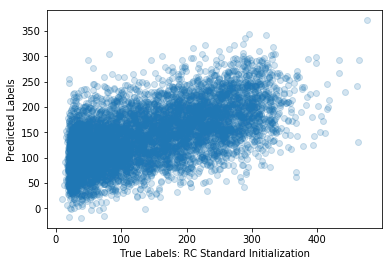

SpearmanrResult(correlation=0.581118759607933, pvalue=0.0)


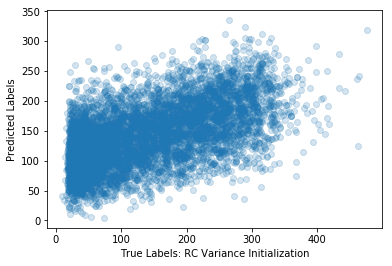

SpearmanrResult(correlation=0.5580116562061559, pvalue=0.0)


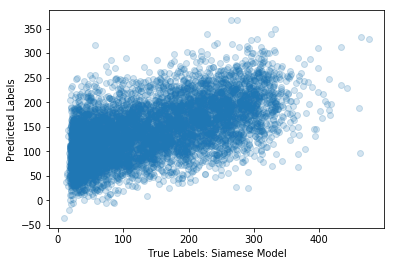

SpearmanrResult(correlation=0.569113388804621, pvalue=0.0)


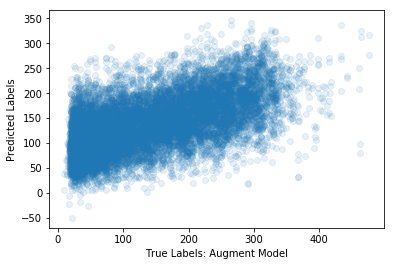

SpearmanrResult(correlation=0.573210890287352, pvalue=0.0)


In [20]:
plt.scatter(y_test, y_pred_standard, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_standard))

plt.scatter(y_test, y_pred_var, alpha = 0.1)
plt.xlabel("True Labels: RC Variance Initialization")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test, y_pred_var))

plt.scatter(y_test, y_pred_siamese, alpha = 0.1)
plt.xlabel("True Labels: Siamese Model")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test, y_pred_siamese))

plt.scatter(y_test_augment, y_pred_augment, alpha = 0.1)
plt.xlabel("True Labels: Augment Model")
plt.ylabel("Predicted Labels")
# plt.plot([np.min(y_test), np.max(y_test)],
#          [np.min(y_pred), np.max(y_test)],
#           color="black")
plt.show()
print(spearmanr(y_test_augment, y_pred_augment))

# Complex Models w/ Dropout: 3 Conv Layers -> Dense Layer (100 Units) -> Output

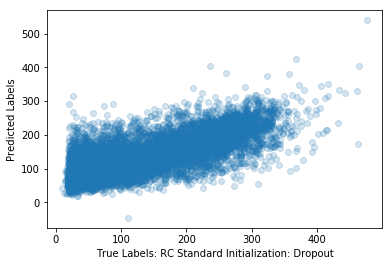

SpearmanrResult(correlation=0.681162555303287, pvalue=0.0)


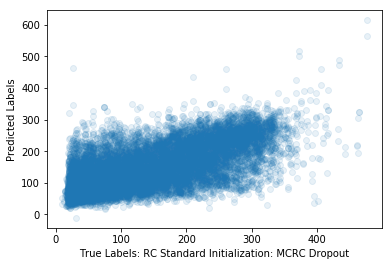

SpearmanrResult(correlation=0.6446344210219405, pvalue=0.0)


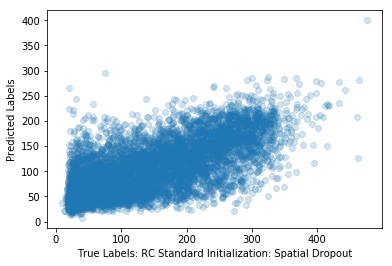

SpearmanrResult(correlation=0.6832397777105094, pvalue=0.0)


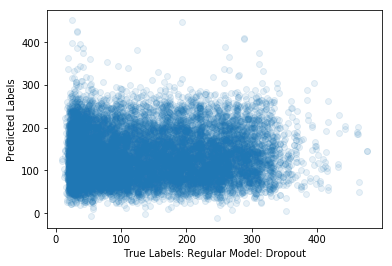

SpearmanrResult(correlation=0.03302051774487579, pvalue=0.0001571664216065531)


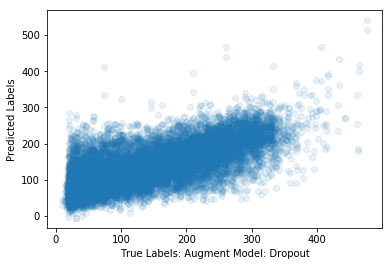

SpearmanrResult(correlation=0.6695384733317233, pvalue=0.0)


In [23]:
plt.scatter(y_test, y_pred_rc_dropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_dropout))

plt.scatter(y_test, y_pred_rc_mcdropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: MCRC Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_mcdropout))

plt.scatter(y_test, y_pred_rc_spatial_dropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: Spatial Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_spatial_dropout))

plt.scatter(y_test, y_pred_reg_dropout, alpha = 0.1)
plt.xlabel("True Labels: Regular Model: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_reg_dropout))

plt.scatter(y_test_augment, y_pred_augment_dropout, alpha = 0.1)
plt.xlabel("True Labels: Augment Model: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test_augment, y_pred_augment_dropout))

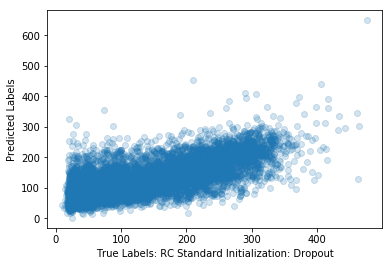

SpearmanrResult(correlation=0.6687902466273974, pvalue=0.0)


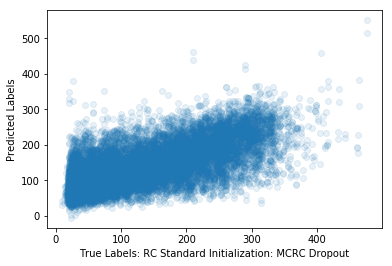

SpearmanrResult(correlation=0.6488986770401852, pvalue=0.0)


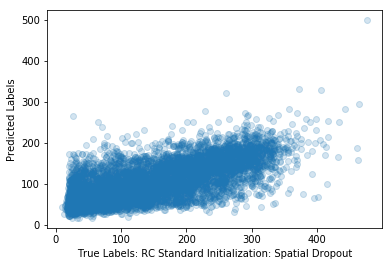

SpearmanrResult(correlation=0.689167242272122, pvalue=0.0)


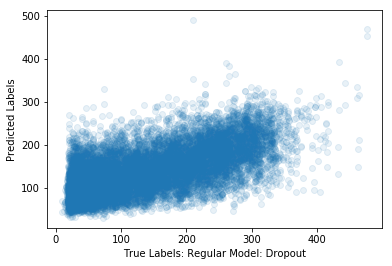

SpearmanrResult(correlation=0.6194402569110398, pvalue=0.0)


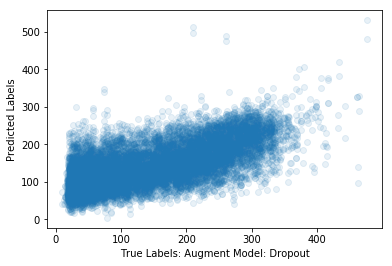

SpearmanrResult(correlation=0.6586903456201354, pvalue=0.0)


In [24]:
plt.scatter(y_test, y_pred_rc_dropout_2, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_dropout_2))

plt.scatter(y_test, y_pred_rc_mcdropout_2, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: MCRC Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_mcdropout_2))

plt.scatter(y_test, y_pred_rc_spatial_dropout_2, alpha = 0.1)
plt.xlabel("True Labels: RC Standard Initialization: Spatial Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_spatial_dropout_2))

plt.scatter(y_test, y_pred_reg_dropout_2, alpha = 0.1)
plt.xlabel("True Labels: Regular Model: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_reg_dropout_2))

plt.scatter(y_test_augment, y_pred_augment_dropout_2, alpha = 0.1)
plt.xlabel("True Labels: Augment Model: Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test_augment, y_pred_augment_dropout_2))

In [25]:
# Complex Models No Dropout: 3 Conv Layers -> Dense Layer (100 Units) -> Output

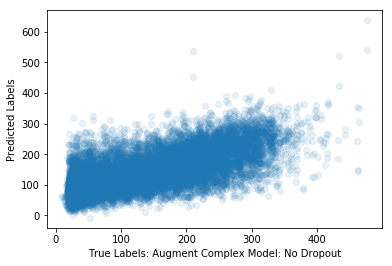

SpearmanrResult(correlation=0.6610212782367162, pvalue=0.0)


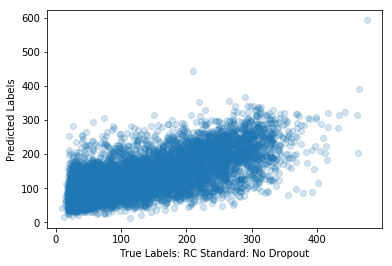

SpearmanrResult(correlation=0.6670740149931798, pvalue=0.0)


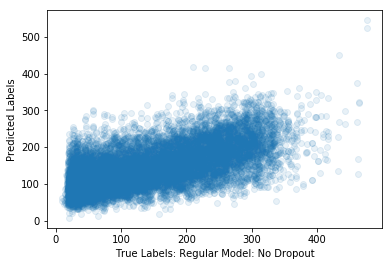

SpearmanrResult(correlation=0.6187263542718199, pvalue=0.0)


In [26]:
plt.scatter(y_test_augment, y_pred_augment_no_dropout, alpha = 0.1)
plt.xlabel("True Labels: Augment Complex Model: No Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test_augment, y_pred_augment_no_dropout))

plt.scatter(y_test, y_pred_rc_standard_no_dropout, alpha = 0.1)
plt.xlabel("True Labels: RC Standard: No Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_rc_standard_no_dropout))

plt.scatter(y_test, y_pred_reg_no_dropout, alpha = 0.1)
plt.xlabel("True Labels: Regular Model: No Dropout")
plt.ylabel("Predicted Labels")
plt.show()
print(spearmanr(y_test, y_pred_reg_no_dropout))